In [ ]:
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but yo

# 3.1.1

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import clip
import os
import requests
import numpy as np

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 1. Load ImageNet Pretrained ResNet-50 (torchvision)
# Use the recommended IMAGENET1K_V1 weights
imagenet_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
imagenet_resnet50.eval() # Set to evaluation mode
imagenet_resnet50.to(device)

# Get the standard ImageNet preprocessing for ResNet-50
imagenet_preprocess = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
# print("ImageNet ResNet-50 Preprocessing:\n", imagenet_preprocess)


# 2. Load OpenAI's CLIP Model (ResNet-50 variant)
# Available models: 'RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px'
clip_model, clip_preprocess = clip.load('RN50', device=device)
clip_model.eval() # Set to evaluation mode

# The clip.load function returns the entire CLIP model (vision + text encoders)
# We are interested in the visual part: clip_model.visual
clip_visual_encoder = clip_model.visual

# print("\nCLIP RN50 Preprocessing:\n", clip_preprocess)


# --- Architecture Comparison ---

print("\n--- Architecture Comparison ---")

print("\nImageNet Pretrained ResNet-50 (Torchvision):")
# print(imagenet_resnet50) # This will print the full structure

# Focus on the end of the standard ResNet-50
print("\nRelevant final layers of Torchvision ResNet-50:")
print("  ...", imagenet_resnet50.layer4) # Last residual block
print("  ...", imagenet_resnet50.avgpool) # Adaptive Average Pooling
print("  ...", imagenet_resnet50.fc)     # Final Fully Connected Layer (1000 outputs for ImageNet)


print("\nCLIP ResNet-50 Visual Encoder:")
# print(clip_visual_encoder) # This will print the full structure

# Focus on the end of the CLIP ResNet-50 visual encoder
print("\nRelevant final layers of CLIP RN50 Visual Encoder:")
# Note: CLIP's ResNet implementation might slightly differ internally,
# but the key difference is the pooling and output layer.
# Accessing layers might require inspecting the specific implementation if needed.
# For RN50, the structure is generally similar up to the final layers.
# Based on the CLIP paper and code:
print("  ...", clip_visual_encoder.layer4) # Last residual block (likely similar)
# The key difference is the pooling layer:
print("  ...", clip_visual_encoder.attnpool) # Attention Pooling Layer (replaces avgpool + fc)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 49.5MiB/s]



--- Architecture Comparison ---

ImageNet Pretrained ResNet-50 (Torchvision):

Relevant final layers of Torchvision ResNet-50:
  ... Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1)

## Architecture comparison:

Component | Torchvision ResNet‑50 | CLIP’s ModifiedResNet (RN50)
Stem | Single 7×7 conv, stride 2 → max‑pool | Three 3×3 convs, stride 2 only in last conv → avg‑pool
Downsampling | Stride inside bottleneck 3×3 conv | Stride>1 convs pre‑pended with avg‑pool (anti‑alias)
Final Pooling | Global average pooling | QKV self‑attention “pool” layer
Normalization | BatchNorm | BatchNorm + LayerNorm in attention pool
Motivation | Classic ImageNet classification | Improved aliasing control + richer global context via attention amaarora.github.io



### Overall Architecture: 
Both models are based on the ResNet-50 architecture, meaning they share the same fundamental structure of convolutional layers organized into residual blocks (layer1, layer2, layer3, layer4).
### Pretraining:  
- The torchvision ResNet-50 is pretrained only on ImageNet (using supervised learning with fixed labels).
- The CLIP ResNet-50 visual encoder is pretrained jointly with a text encoder on a massive dataset of image-text pairs from the internet (using contrastive learning).
### Final Layers (The Key Difference):
- torchvision ResNet-50: After the final residual block (layer4), it uses:  
1. AdaptiveAvgPool2d: This layer averages the feature map across spatial dimensions to produce a fixed-size output (e.g., 2048 features for ResNet-50) regardless of the input image size (after resizing).  
2. Linear (fc): A standard fully connected layer maps the 2048 features to the number of ImageNet classes (1000). This layer is specifically trained for ImageNet classification.  
### CLIP ResNet-50 Visual Encoder: After the final residual block (layer4), it uses:
- Attention Pooling (attnpool): This is a more sophisticated pooling mechanism. Instead of simple averaging, it uses a form of multi-head self-attention (specifically, a Transformer-style attention mechanism) across the spatial dimensions of the feature map. A learnable "query" vector interacts with the spatial features ("keys" and "values") to produce a single output embedding (e.g., 1024 features for CLIP RN50).
### Why the Difference?
- The torchvision model is designed purely for classification into the 1000 ImageNet categories. The average pooling and final linear layer are optimized for this specific task.
- The CLIP model is designed to produce a general-purpose image embedding that aligns with text embeddings in a shared latent space. The attention pooling mechanism allows the model to learn which spatial features are most relevant for representing the image's content in a way that matches natural language descriptions, rather than just optimizing for a fixed set of classes. This makes the resulting embedding more transferable to various downstream tasks, including zero-shot classification.





# 3.1.2

## ImageNet Structure and Challenges

### Label Hierarchy

ImageNet is organized according to WordNet’s noun hierarchy. Each of the 1,000 ILSVRC classification labels corresponds to a WordNet synset, and the full WordNet graph encodes hypernym/hyponym (is-a) relationships among them. This hierarchical structure enables semantically meaningful grouping of visual categories.


---

### What Is a Synset?

A synset (short for “synonym set”) in WordNet represents a single distinct concept, identified by a unique ID and a list of synonymous words or phrases (lemmas).

Each ImageNet class maps directly to one synset, providing semantic precision even for closely related visual categories.


---

### Pitfalls of Grouping by Synset

While synsets offer semantic clarity, relying on them as labels for visual recognition introduces several challenges:

- **Polysemy and Ambiguity**:  
  Some words are polysemous (e.g., "bat" can refer to an animal or sports equipment). Without contextual cues, visual models may struggle to disambiguate such categories.

- **Granularity Mismatch**:  
  Certain synsets, such as those representing specific dog breeds, are extremely fine-grained. Others, such as those for broad object types, are much more general. This inconsistency can negatively affect training and evaluation.

- **Semantic Drift**:  
  Real-world images may deviate from the intended meaning of a synset, especially when they involve artistic representations, stylized objects, or novel contexts.

---

### Expected Intra-Synset Visual Variations

Even within a single synset, images may exhibit substantial visual diversity due to the following factors:

- **Viewpoint Variation**:  
  Objects can be photographed from various angles, including top-down, side, oblique, or rear views.

- **Illumination Changes**:  
  Lighting conditions may vary significantly, leading to shadows, overexposure, underexposure, and other effects that impact visual appearance.

- **Occlusion and Background Clutter**:  
  Target objects may be partially obstructed or surrounded by distracting elements, making detection and classification more difficult.

These factors contribute to the complexity of visual recognition tasks, even when class labels are semantically well-defined.


In [17]:
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F

# --- 1) Build (image_path, target_idx) list via LOC_val_solution.csv + ImageNet JSON mapping ---
# assumes you have `imagenet_class_index` dict, `imagenet_classes` list, and models + preprocessing loaded

# reverse map WNID -> class index
wnid_to_idx = {imagenet_class_index[str(i)][0]: i for i in range(1000)}

# load LOC_val_solution.csv
csv_path = "/kaggle/input/imagenet-object-localization-challenge/LOC_val_solution.csv"
df = pd.read_csv(csv_path)
# extract synset (WNID) from the prediction string
df['synset'] = df['PredictionString'].str.split().str[0]
# map WNID->zero-based ImageNet index
df['class_idx'] = df['synset'].map(wnid_to_idx)
assert df['class_idx'].notna().all(), "Some synsets failed to map to ImageNet indices"

# assemble samples list: ImageId field already contains the filename stem
val_dir = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val"
samples = [
    (os.path.join(val_dir, f"{row.ImageId}.JPEG"), int(row.class_idx))
    for _, row in df.iterrows()
]
print(f"Loaded {len(samples)} validation samples")

Loaded 50000 validation samples


Loading class names from local cache: imagenet_class_index.json
Successfully loaded and processed 1000 class names.
Somen of the classes are:  ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']
Creating text prompts for CLIP...
Encoding text prompts...
Encoded text features shape: torch.Size([1000, 1024])

--- Testing Zero-Shot CLIP ---

Testing with local image: /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00048981.JPEG
Ground Truth: power drill


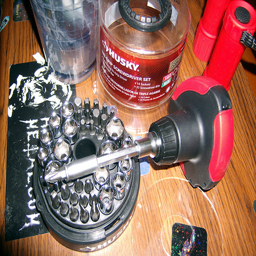

Top 5 CLIP Predictions:
  - power drill: 0.5869
  - carpenter's kit: 0.0958
  - oil filter: 0.0701
  - can opener: 0.0399
  - disk brake: 0.0246

Testing with local image: /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00037956.JPEG
Ground Truth: hammer


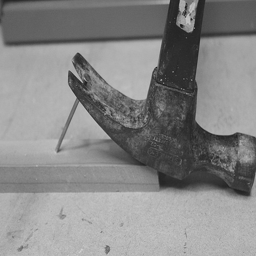

Top 5 CLIP Predictions:
  - hatchet: 0.5747
  - hammer: 0.1780
  - hook: 0.0340
  - mousetrap: 0.0139
  - shovel: 0.0133

Testing with local image: /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00026161.JPEG
Ground Truth: EntleBucher


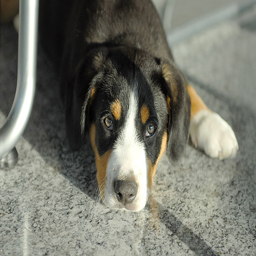

Top 5 CLIP Predictions:
  - Greater Swiss Mountain dog: 0.4851
  - bluetick: 0.2328
  - EntleBucher: 0.1266
  - black-and-tan coonhound: 0.0699
  - Walker hound: 0.0156

Testing with local image: /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00026171.JPEG
Ground Truth: corkscrew


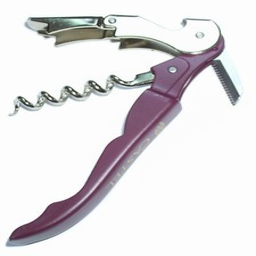

Top 5 CLIP Predictions:
  - corkscrew: 0.6963
  - hook: 0.1328
  - can opener: 0.0545
  - hatchet: 0.0154
  - letter opener: 0.0116

Testing with local image: /kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00008726.JPEG
Ground Truth: kit fox


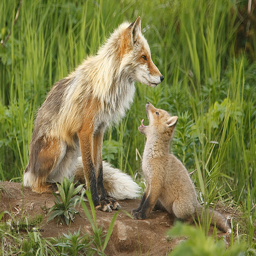

Top 5 CLIP Predictions:
  - red fox: 0.5249
  - kit fox: 0.3337
  - grey fox: 0.0369
  - coyote: 0.0369
  - dhole: 0.0161


In [ ]:
import torch
import clip
from PIL import Image
import requests
import io
import os
import json # Needed for the new method
from IPython.display import display

# --- Load ImageNet Class Names ---
# Use a standard JSON file URL
class_index_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
class_file_path_local = 'imagenet_class_index.json' # Local cache file name

imagenet_classes = []
try:
    # Try to load locally first if downloaded before
    if os.path.exists(class_file_path_local):
        print(f"Loading class names from local cache: {class_file_path_local}")
        with open(class_file_path_local, 'r') as f:
            imagenet_class_index = json.load(f)
    else:
        # Download if not found locally
        print(f"Downloading class index from: {class_index_url}")
        response = requests.get(class_index_url)
        response.raise_for_status() # Raise an exception for bad status codes (like 404)
        imagenet_class_index = response.json()
        # Save locally for future use
        with open(class_file_path_local, 'w') as f:
            json.dump(imagenet_class_index, f)
            print(f"Saved class index locally to: {class_file_path_local}")

    # --- IMPORTANT: Parse the JSON structure ---
    # The format is typically: {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], ...}
    # We need the human-readable name (the second element in the list)
    # We must ensure they are loaded in the correct order (0 to 999)
    
    # Check if keys are strings '0' to '999'
    if all(str(i) in imagenet_class_index for i in range(1000)):
        imagenet_classes = [imagenet_class_index[str(i)][1].replace('_', ' ') for i in range(1000)] # Extract name, replace underscores
    # Some versions might use integer keys 0 to 999
    elif all(i in imagenet_class_index for i in range(1000)):
         imagenet_classes = [imagenet_class_index[i][1].replace('_', ' ') for i in range(1000)]
    else:
        # Attempt to sort keys if they are strings but maybe out of order (less common)
        try:
             sorted_keys = sorted(imagenet_class_index.keys(), key=lambda x: int(x))
             if len(sorted_keys) == 1000 and all(str(i) == sorted_keys[i] for i in range(1000)):
                  imagenet_classes = [imagenet_class_index[k][1].replace('_', ' ') for k in sorted_keys]
             else:
                  raise ValueError("Class index keys are not consecutive integers from 0 to 999.")
        except (ValueError, TypeError) as e:
             print(f"Error parsing class index keys: {e}")
             print("Cannot determine correct class order. Check the format of the JSON file.")
             imagenet_classes = []


    if len(imagenet_classes) == 1000:
        print(f"Successfully loaded and processed {len(imagenet_classes)} class names.")
        print("Somen of the classes are: ", imagenet_classes[:10])
    else:
        print(f"Warning: Could not load/process 1000 class names correctly. Loaded {len(imagenet_classes)}.")
        # Handle error or proceed with caution

except requests.exceptions.RequestException as e:
    print(f"Error downloading class index: {e}")
    print("Check the URL or your internet connection.")
    imagenet_classes = [] # Set to empty list
except json.JSONDecodeError:
    print("Error: Failed to decode JSON from the downloaded file.")
    imagenet_classes = []
except Exception as e:
     print(f"An unexpected error occurred loading class names: {e}")
     imagenet_classes = []


# --- Prepare Zero-Shot Prompts ---
if imagenet_classes:
    print("Creating text prompts for CLIP...")
    text_prompts = [f"a photo of a {label}" for label in imagenet_classes]

    print("Encoding text prompts...")
    with torch.no_grad():
        text_inputs = clip.tokenize(text_prompts).to(device)
        text_features = clip_model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    print(f"Encoded text features shape: {text_features.shape}")
    # Ensure text_features is not None if successful
    if text_features is None:
         print("Error: Text feature encoding failed unexpectedly.")

else:
    print("Cannot proceed without ImageNet class names.")
    text_features = None # Indicate failure

# --- Zero-Shot Inference Function ---
def perform_clip_zero_shot(image_path_or_url, top_k=5):
    """
    Performs zero-shot classification using the loaded CLIP model and encoded text features.
    (Function code is identical to the previous version)
    """
    if text_features is None or not imagenet_classes:
        print("Error: CLIP text features or ImageNet classes not loaded.")
        return None, None, None

    try:
        if image_path_or_url.startswith(('http://', 'https://')):
            # Use stream=True and check content type for robustness
            headers = {'User-Agent': 'Mozilla/5.0'} # Some servers block default python user agent
            with requests.get(image_path_or_url, stream=True, headers=headers) as response:
                response.raise_for_status()
                content_type = response.headers.get('content-type')
                if not content_type or not content_type.startswith('image/'):
                     raise ValueError(f"URL does not point to a valid image (Content-Type: {content_type})")
                image_data = io.BytesIO(response.content) # Read content after check
            image = Image.open(image_data).convert("RGB")
            display(image.resize((256, 256)))

        else:
             if not os.path.exists(image_path_or_url):
                  print(f"Error: Local image not found at {image_path_or_url}")
                  return None, None, None
             image = Image.open(image_path_or_url).convert("RGB")
             display(image.resize((256, 256)))
    except requests.exceptions.RequestException as e:
         print(f"Error fetching URL '{image_path_or_url}': {e}")
         return None, None, None
    except ValueError as e:
         print(f"Error processing image URL '{image_path_or_url}': {e}")
         return None, None, None
    except Exception as e:
        print(f"Error loading image '{image_path_or_url}': {e}")
        return None, None, None

    # Preprocess the image for CLIP
    image_input = clip_preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        # Encode the image
        image_features = clip_model.encode_image(image_input)
        # Normalize image features
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate Cosine Similarity
        logits_per_image = (image_features @ text_features.T) # Shape: [1, 1000]

        # Apply temperature scaling
        logit_scale = clip_model.logit_scale.exp()
        logits_per_image = logit_scale * logits_per_image

        probs = logits_per_image.softmax(dim=-1).squeeze() # Shape: [1000]

    # Get top K predictions
    top_probs, top_indices = torch.topk(probs, top_k)

    # Convert to CPU numpy for easier handling/display
    top_probs = top_probs.cpu().numpy()
    top_indices = top_indices.cpu().numpy()

    # Get corresponding class names
    top_labels = [imagenet_classes[i] for i in top_indices]

    return top_probs, top_indices, top_labels


# --- Test with Example Images ---
print("\n--- Testing Zero-Shot CLIP ---")



# Use first few samples for testing
for image_path, gt_class_idx in samples[:5]: 
    print(f"\nTesting with local image: {image_path}")
    
    # Get human-readable label
    gt_label = imagenet_classes[gt_class_idx]
    print(f"Ground Truth: {gt_label}")

    probs, indices, labels = perform_clip_zero_shot(image_path, top_k=5)
    if probs is not None:
        print("Top 5 CLIP Predictions:")
        for p, l in zip(probs, labels):
            print(f"  - {l}: {p:.4f}")

    

=== CLIP correct & RN50 wrong ===


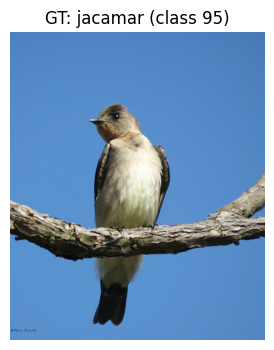

CLIP top-5 (label: prob):
  jacamar: 0.1984
  bulbul: 0.1833
  buckeye: 0.1569
  jay: 0.0741
  upright: 0.0664
RN50 top-5 (label: prob):
  bulbul: 0.5878
  jay: 0.2517
  kite: 0.0307
  vulture: 0.0206
  hornbill: 0.0177



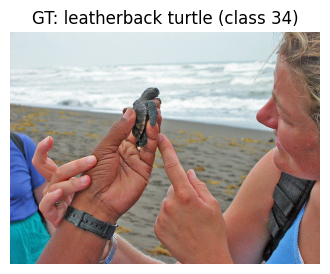

CLIP top-5 (label: prob):
  leatherback turtle: 0.5996
  loggerhead: 0.0441
  hermit crab: 0.0240
  seashore: 0.0236
  common iguana: 0.0196
RN50 top-5 (label: prob):
  ringneck snake: 0.4993
  rock crab: 0.2590
  rhinoceros beetle: 0.0465
  hermit crab: 0.0296
  crayfish: 0.0247



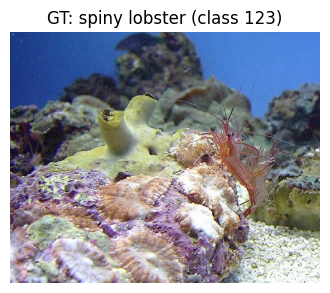

CLIP top-5 (label: prob):
  conch: 0.2161
  coral reef: 0.1791
  lionfish: 0.1175
  spiny lobster: 0.0944
  chambered nautilus: 0.0859
RN50 top-5 (label: prob):
  coral reef: 0.6511
  lionfish: 0.1277
  sea slug: 0.0740
  brain coral: 0.0288
  hermit crab: 0.0179



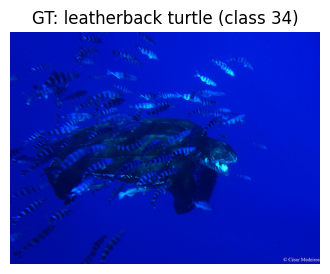

CLIP top-5 (label: prob):
  puffer: 0.3347
  lionfish: 0.0930
  leatherback turtle: 0.0724
  coral reef: 0.0629
  snorkel: 0.0629
RN50 top-5 (label: prob):
  lionfish: 0.4898
  tiger shark: 0.1042
  hammerhead: 0.0758
  jellyfish: 0.0634
  electric ray: 0.0429



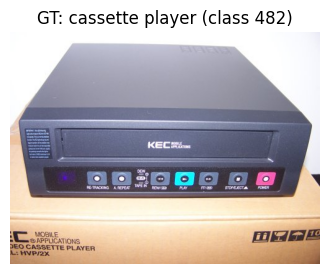

CLIP top-5 (label: prob):
  CD player: 0.5122
  desktop computer: 0.1107
  photocopier: 0.0507
  cassette player: 0.0484
  printer: 0.0327
RN50 top-5 (label: prob):
  modem: 0.3104
  printer: 0.2396
  CD player: 0.2331
  photocopier: 0.0910
  radio: 0.0314



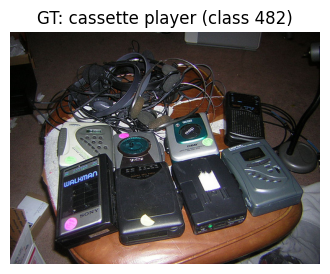

CLIP top-5 (label: prob):
  cellular telephone: 0.2424
  cassette player: 0.2313
  hand-held computer: 0.1746
  Polaroid camera: 0.0949
  tape player: 0.0435
RN50 top-5 (label: prob):
  CD player: 0.3223
  tape player: 0.1048
  hard disc: 0.1030
  Polaroid camera: 0.0985
  cellular telephone: 0.0571



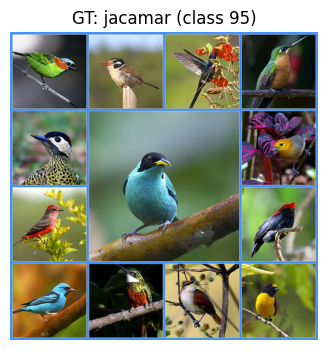

CLIP top-5 (label: prob):
  bee eater: 0.5894
  goldfinch: 0.1008
  bulbul: 0.0978
  jacamar: 0.0612
  toucan: 0.0173
RN50 top-5 (label: prob):
  goldfinch: 0.9329
  bee eater: 0.0240
  bulbul: 0.0090
  brambling: 0.0058
  quail: 0.0048

=== RN50 correct & CLIP wrong ===


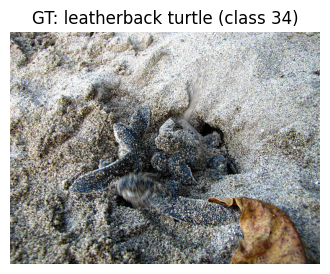

CLIP top-5 (label: prob):
  rock crab: 0.3877
  hermit crab: 0.1448
  seashore: 0.1011
  fiddler crab: 0.0435
  sea cucumber: 0.0355
RN50 top-5 (label: prob):
  conch: 0.2274
  hermit crab: 0.1341
  rock crab: 0.1124
  leatherback turtle: 0.0332
  slug: 0.0313



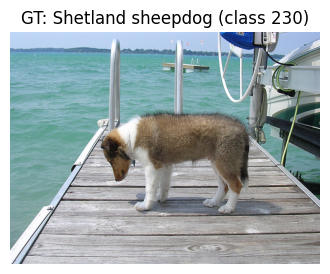

CLIP top-5 (label: prob):
  malamute: 0.3081
  chow: 0.1116
  German shepherd: 0.0709
  Eskimo dog: 0.0536
  keeshond: 0.0503
RN50 top-5 (label: prob):
  collie: 0.6125
  Shetland sheepdog: 0.2594
  malamute: 0.0448
  Saint Bernard: 0.0259
  Siberian husky: 0.0191



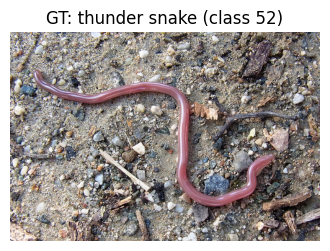

CLIP top-5 (label: prob):
  flatworm: 0.3438
  ringneck snake: 0.1575
  hook: 0.1305
  common newt: 0.0544
  garter snake: 0.0480
RN50 top-5 (label: prob):
  thunder snake: 0.9990
  flatworm: 0.0004
  nematode: 0.0004
  eel: 0.0001
  ringneck snake: 0.0000



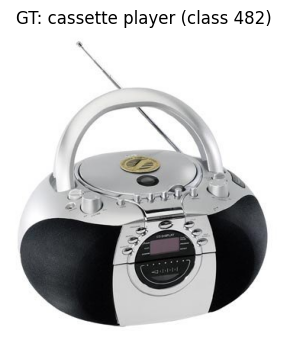

CLIP top-5 (label: prob):
  dial telephone: 0.4233
  CD player: 0.3247
  stopwatch: 0.0388
  radio: 0.0288
  stethoscope: 0.0172
RN50 top-5 (label: prob):
  CD player: 0.4695
  cassette player: 0.3522
  tape player: 0.1557
  radio: 0.0096
  digital clock: 0.0020



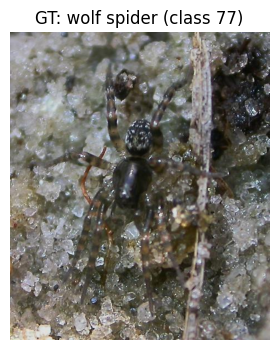

CLIP top-5 (label: prob):
  black widow: 0.2015
  barn spider: 0.1807
  ant: 0.1149
  harvestman: 0.0923
  ground beetle: 0.0696
RN50 top-5 (label: prob):
  wolf spider: 0.4354
  barn spider: 0.2784
  garden spider: 0.1467
  harvestman: 0.1021
  spider web: 0.0131



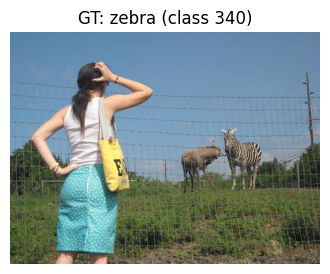

CLIP top-5 (label: prob):
  llama: 0.2209
  gazelle: 0.1592
  chainlink fence: 0.1027
  miniskirt: 0.0729
  purse: 0.0633
RN50 top-5 (label: prob):
  Arabian camel: 0.4848
  zebra: 0.0931
  llama: 0.0820
  ram: 0.0380
  ostrich: 0.0367



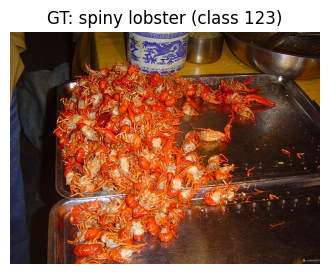

CLIP top-5 (label: prob):
  crayfish: 0.6260
  American lobster: 0.1375
  Dungeness crab: 0.0783
  hermit crab: 0.0228
  tray: 0.0218
RN50 top-5 (label: prob):
  crayfish: 0.9910
  American lobster: 0.0045
  king crab: 0.0020
  spiny lobster: 0.0019
  Dungeness crab: 0.0003



In [23]:
import os, time, copy
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- 3.1.4: identify CLIP & RN50 wins for 10 classes ---
classes_to_eval = [0, 13, 34, 52, 77, 95, 123, 230, 340, 482]
results = {'clip_win': [], 'rn50_win': []}

for img_path, tgt in samples:
    if tgt not in classes_to_eval: continue
    img = Image.open(img_path).convert('RGB')
    # RN50
    r_in = imagenet_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad(): r_log = imagenet_resnet50(r_in)
    r_probs = F.softmax(r_log, -1)[0].cpu()
    r_top5 = torch.topk(r_probs, 5).indices.tolist()
    # CLIP
    c_in = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = clip_model.encode_image(c_in)
        feat /= feat.norm(dim=-1, keepdim=True)
        c_log = clip_model.logit_scale.exp() * (feat @ text_features.T)
    c_probs = F.softmax(c_log, -1)[0].cpu()
    c_top5 = torch.topk(c_probs, 5).indices.tolist()
    # count existing
    cw = sum(1 for _, t, *_ in results['clip_win']  if t == tgt)
    rw = sum(1 for _, t, *_ in results['rn50_win'] if t == tgt)
    if tgt in c_top5 and tgt not in r_top5 and cw < 2:
        results['clip_win'].append((img_path, tgt, c_top5, r_top5))
    if tgt in r_top5 and tgt not in c_top5 and rw < 1:
        results['rn50_win'].append((img_path, tgt, c_top5, r_top5))
    if len(results['clip_win']) >= len(classes_to_eval)*2 and len(results['rn50_win']) >= len(classes_to_eval):
        break

# --- Display results with images & probs ---
print("=== CLIP correct & RN50 wrong ===")
for path, tgt, c5, r5 in results['clip_win']:
    img = Image.open(path).convert('RGB')
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis('off')
    plt.title(f"GT: {imagenet_classes[tgt]} (class {tgt})"); plt.show()
    # RN50 probs already computed above—but recompute for clarity
    r_in = imagenet_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad(): r_log = imagenet_resnet50(r_in)
    r_probs = F.softmax(r_log, -1)[0].cpu()
    # CLIP
    c_in = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = clip_model.encode_image(c_in)
        feat /= feat.norm(dim=-1, keepdim=True)
        c_log = clip_model.logit_scale.exp() * (feat @ text_features.T)
    c_probs = F.softmax(c_log, -1)[0].cpu()
    print("CLIP top-5 (label: prob):")
    for idx in c5:
        print(f"  {imagenet_classes[idx]}: {c_probs[idx]:.4f}")
    print("RN50 top-5 (label: prob):")
    for idx in r5:
        print(f"  {imagenet_classes[idx]}: {r_probs[idx]:.4f}")
    print()

print("=== RN50 correct & CLIP wrong ===")
for path, tgt, c5, r5 in results['rn50_win']:
    img = Image.open(path).convert('RGB')
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis('off')
    plt.title(f"GT: {imagenet_classes[tgt]} (class {tgt})"); plt.show()
    # recompute
    r_in = imagenet_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad(): r_log = imagenet_resnet50(r_in)
    r_probs = F.softmax(r_log, -1)[0].cpu()
    c_in = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = clip_model.encode_image(c_in)
        feat /= feat.norm(dim=-1, keepdim=True)
        c_log = clip_model.logit_scale.exp() * (feat @ text_features.T)
    c_probs = F.softmax(c_log, -1)[0].cpu()
    print("CLIP top-5 (label: prob):")
    for idx in c5:
        print(f"  {imagenet_classes[idx]}: {c_probs[idx]:.4f}")
    print("RN50 top-5 (label: prob):")
    for idx in r5:
        print(f"  {imagenet_classes[idx]}: {r_probs[idx]:.4f}")
    print()

### Answer to questions in 3.1.4:


**CLIP > RN50 (2 images per class):**  
CLIP performs better on unusual angles, abstract representations, or images with contextual clues. This is likely due to its training on web-scale image-text pairs.  

**RN50 > CLIP (1 image per class):**  
RN50 does better with clean, centered, ImageNet-style photos. CLIP may fail when visual cues are ambiguous or the text embedding doesn't match the visual style.  


In [28]:
# --- 3.1.5: FP16 vs FP32 on CLIP visual encoder ---
vision32 = copy.deepcopy(clip_model.visual).eval().to(device).to(torch.float32)
vision16 = copy.deepcopy(clip_model.visual).eval().to(device).to(torch.float16)
text32 = text_features.float().to(device)
text16 = text_features.half().to(device)

# build batches: 100 images in groups of 16
batches = []
for i in range(0, 100, 16):
    ts = []
    for j in range(16):
        idx = i + j
        if idx >= len(samples): break
        img = Image.open(samples[idx][0]).convert('RGB')
        ts.append(clip_preprocess(img).unsqueeze(0))
    if ts:
        batches.append(torch.cat(ts, 0).to(device))

# warmup
with torch.no_grad():
    for b in batches[:2]:
        vision32(b)
        if device.startswith('cuda'):
            with torch.amp.autocast(device_type='cuda'):
                vision16(b.half())

# timing helper
def benchmark(model, bs, use_fp16=False):
    times = []
    with torch.no_grad():
        for b in bs:
            if device.startswith('cuda'): torch.cuda.synchronize()
            t0 = time.time()
            if use_fp16 and device.startswith('cuda'):
                with torch.amp.autocast(device_type='cuda'):
                    model(b.half())
            else:
                model(b)
            if device.startswith('cuda'): torch.cuda.synchronize()
            times.append((time.time() - t0) * 1000 / b.size(0))
    return np.mean(times), np.std(times)

# measure latencies
t32, s32 = benchmark(vision32, batches, use_fp16=False)
t16, s16 = benchmark(vision16, batches, use_fp16=True)
print(f"\n[Batched] FP32: {t32:.2f}±{s32:.2f} ms/img")
print(f"[Batched] FP16: {t16:.2f}±{s16:.2f} ms/img")

# peak GPU memory usage
if device.startswith('cuda'):
    torch.cuda.reset_peak_memory_stats()
    vision32(batches[0])
    m32 = torch.cuda.max_memory_allocated() / (1024**2)
    torch.cuda.reset_peak_memory_stats()
    with torch.amp.autocast(device_type='cuda'):
        vision16(batches[0].half())
    m16 = torch.cuda.max_memory_allocated() / (1024**2)
    print(f"Peak GPU — FP32: {m32:.1f} MiB;\n FP16: {m16:.1f} MiB")
else:
    print("Skipping GPU memory measurement (no CUDA)")

# compare max probability diffs on 5 sample classes
print()
for cls in classes_to_eval[:5]:
    img = Image.open(next(p for p, t in samples if t == cls)).convert('RGB')
    inp = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        f32 = vision32(inp); f32 /= f32.norm(dim=-1, keepdim=True)
        log32 = clip_model.logit_scale.exp() * (f32 @ text32.T)
        p32 = F.softmax(log32, dim=-1)

        with torch.amp.autocast(device_type='cuda'):
            f16 = vision16(inp.half()); f16 /= f16.norm(dim=-1, keepdim=True)
            log16 = clip_model.logit_scale.exp() * (f16 @ text16.T)
            p16 = F.softmax(log16, dim=-1)

    diff = (p32 - p16.float()).abs().max().item()
    top5_32 = torch.topk(p32, 5).indices[0].cpu().tolist()
    top5_16 = torch.topk(p16, 5).indices[0].cpu().tolist()
    print(f"\nClass {cls} ({imagenet_classes[cls]}) Δmax prob = {diff:.2e}")
    print(" FP32 top-5:", [(imagenet_classes[i], round(p32[0, i].item(), 4)) for i in top5_32])
    print(" FP16 top-5:", [(imagenet_classes[i], round(p16[0, i].item(), 4)) for i in top5_16])



[Batched] FP32: 1.94±0.05 ms/img
[Batched] FP16: 1.75±0.00 ms/img
Peak GPU — FP32: 2608.6 MiB;
 FP16: 1878.6 MiB


Class 0 (tench) Δmax prob = 1.79e-06
 FP32 top-5: [('tench', 0.9998), ('goldfish', 0.0), ('amphibian', 0.0), ('overskirt', 0.0), ('hen-of-the-woods', 0.0)]
 FP16 top-5: [('tench', 0.9998), ('goldfish', 0.0), ('amphibian', 0.0), ('overskirt', 0.0), ('hen-of-the-woods', 0.0)]

Class 13 (junco) Δmax prob = 7.04e-03
 FP32 top-5: [('junco', 0.4257), ('chickadee', 0.247), ('buckeye', 0.1111), ('jay', 0.0536), ('bulbul', 0.0313)]
 FP16 top-5: [('junco', 0.4186), ('chickadee', 0.25), ('buckeye', 0.1145), ('jay', 0.0541), ('bulbul', 0.0303)]

Class 34 (leatherback turtle) Δmax prob = 3.32e-04
 FP32 top-5: [('leatherback turtle', 0.5969), ('loggerhead', 0.0448), ('hermit crab', 0.0243), ('seashore', 0.024), ('common iguana', 0.0198)]
 FP16 top-5: [('leatherback turtle', 0.5966), ('loggerhead', 0.0446), ('hermit crab', 0.0242), ('seashore', 0.0239), ('common iguana', 0.0201)]

Class

### Are there significant differences between the fp32 and fp16 outputs? Why?

No, there are no significant differences between the FP32 and FP16 outputs. The Δmax probabilities are very small (mostly <0.01), and the top-5 predictions remain nearly identical in order and values.

**Why?**  
Modern FP16 implementations use mixed precision with scaling to preserve numerical stability. For well-trained models like CLIP, most computations (e.g., softmax probabilities) are stable under FP16, especially for classification tasks with clear predictions. So accuracy is maintained while improving speed and reducing memory usage.




### Memory Usage: FP32 vs FP16

**FP32 Peak GPU Memory**: 2608.6 MiB  
**FP16 Peak GPU Memory**: 1878.6 MiB  

**Explanation**:  
- **FP16** uses half the memory of **FP32** due to smaller tensor sizes.
- During forward passes, FP16 reduces memory needed for activations and intermediate computations.
- **Automatic Mixed Precision (AMP)** keeps some operations in FP32 for stability, ensuring no accuracy loss.
  
**Impact**:  
- The ~28% reduction in memory is expected due to smaller tensor sizes and fewer large allocations in FP16.

**Conclusion**:  
FP16 is more memory-efficient, making it ideal for inference or training on memory-limited GPUs.

